# Credit Risk Analysis

Data source : https://www.kaggle.com/datasets/atulmittal199174/credit-risk-analysis-for-extending-bank-loans

## Import Libraries

In [96]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from feature_engine.outliers import OutlierTrimmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline,make_pipeline

## Data Loading

In [2]:
df = pd.read_csv('bankloans.csv')
df.head(5)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1150 non-null   int64  
 1   ed        1150 non-null   int64  
 2   employ    1150 non-null   int64  
 3   address   1150 non-null   int64  
 4   income    1150 non-null   int64  
 5   debtinc   1150 non-null   float64
 6   creddebt  1150 non-null   float64
 7   othdebt   1150 non-null   float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 81.0 KB


Penjelasan untuk masing - masing column yang digunakan :
- age : age of the customers
- ed : education level
- employ : work experience
- address : address of the customer
- income : yearly income of the customer
- debtinc : debt to income ratio
- creddebt : credit to debt ratio
- otherdebt : other debts
- default : decision about credit risk ( 1 - yes, 0 - no)

In [4]:
df = df.rename(columns={'ed':'education_level',
                        'employ':'work_experience',
                        'address':'customer_address',
                        'income':'yearly_income',
                        'debtinc':'debt_to_income',
                        'creddebt':'credit_to_debt',
                        'othdebt':'other_debts',
                        'default':'credit_result'})

In [5]:
df.describe()

,age,education_level,work_experience,customer_address,yearly_income,debt_to_income,credit_to_debt,other_debts,credit_result
count,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,700.000000
mean,35.235652,1.695652,8.781739,8.485217,47.982609,10.063391,1.605111,3.103844,0.261429
std,8.089961,0.927051,6.914762,6.977725,40.508814,6.584288,2.135967,3.529273,0.439727
min,20.000000,1.000000,0.000000,0.000000,13.000000,0.100000,0.011696,0.045584,0.000000
25%,29.000000,1.000000,3.000000,3.000000,24.000000,5.200000,0.415584,1.047996,0.000000
50%,35.000000,1.000000,7.000000,7.000000,36.000000,8.750000,0.899130,2.038053,0.000000
75%,41.000000,2.000000,13.000000,12.000000,56.750000,13.600000,1.898820,3.864960,1.000000
max,56.000000,5.000000,33.000000,34.000000,446.000000,41.300000,20.561310,35.197500,1.000000


In [6]:
for item in (df.columns):
    print('Unique value untuk ',item,' :',df[item].nunique())

Unique value untuk  age  : 37
Unique value untuk  education_level  : 5
Unique value untuk  work_experience  : 33
Unique value untuk  customer_address  : 32
Unique value untuk  yearly_income  : 129
Unique value untuk  debt_to_income  : 245
Unique value untuk  credit_to_debt  : 842
Unique value untuk  other_debts  : 848
Unique value untuk  credit_result  : 2


In [7]:
df['education_level'].unique().tolist()

[3, 1, 2, 4, 5]

In [8]:
result_index = df[df['credit_result'].isna()==True].index
result_index

Int64Index([ 700,  701,  702,  703,  704,  705,  706,  707,  708,  709,
            ...
            1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149],
           dtype='int64', length=450)

In [9]:
df.drop(result_index,inplace=True)
df

,age,education_level,work_experience,customer_address,yearly_income,debt_to_income,credit_to_debt,other_debts,credit_result
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...,...,...,...
695,36,2,6,15,27,4.6,0.262062,0.979938,1.0
696,29,2,6,4,21,11.5,0.369495,2.045505,0.0
697,33,1,15,3,32,7.6,0.491264,1.940736,0.0
698,45,1,19,22,77,8.4,2.302608,4.165392,0.0


## Exploratory Data Analysis (EDA)

### Checking Distribution of Each Columns

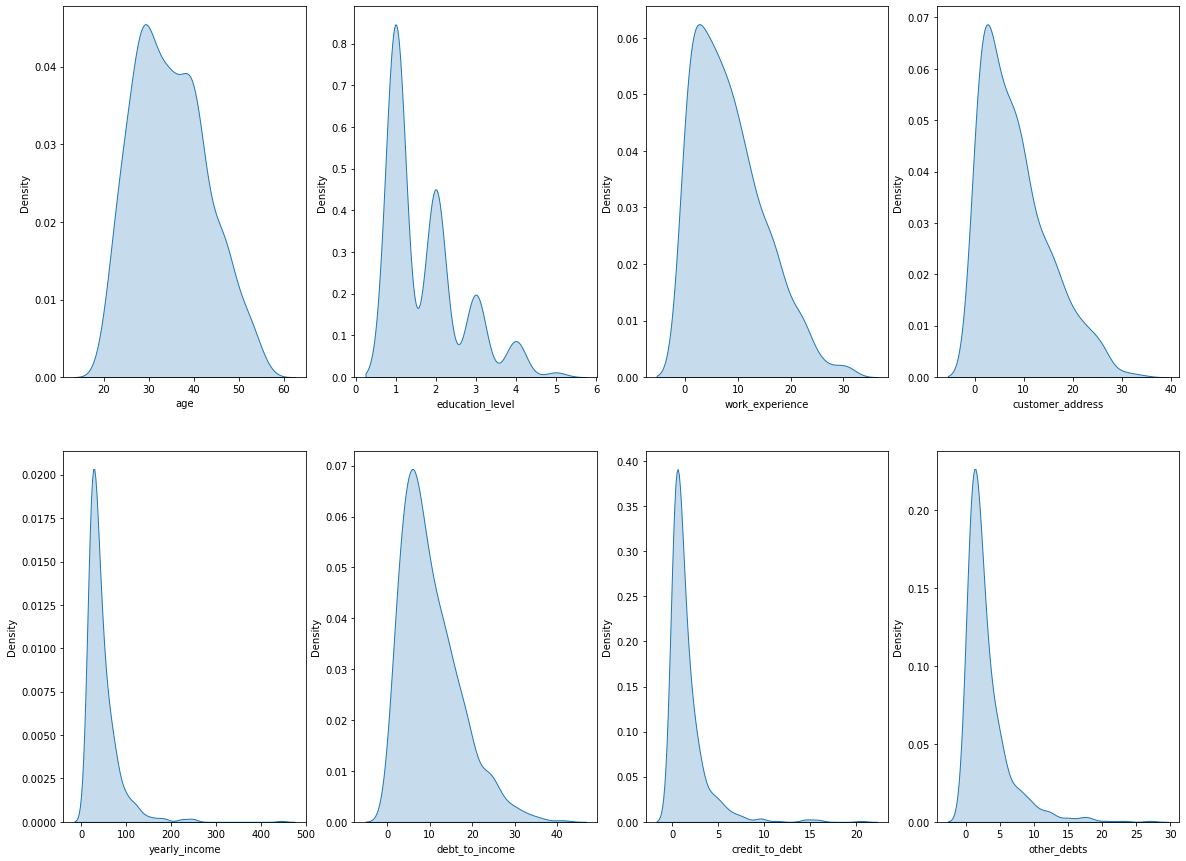

In [10]:
i = 0
j = 0
fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(20,15))
for item in df.columns.tolist():
    sns.kdeplot(data=df,x=item,ax=axes[i][j],fill=True)
    j+=1
    if j>3:
        j=0
        i+=1
        if i>1:
            break

Kalau lebih dari 0.5, maka right skew
Kalau kurang dari 0.5, maka left skew
Kalau tidak keduanya, maka normal

In [11]:
for item in df.columns.tolist():
    if df[item].skew() > -0.5 and df[item].skew() < 0.5:
        print('Skewness untuk column {} adalah {}, distribusi : Normal'.format(item,df[item].skew()))
    else :
        print('Skewness untuk column {} adalah {}, distribusi : Skew'.format(item,df[item].skew()))

Skewness untuk column age adalah 0.36147820320045854, distribusi : Normal
Skewness untuk column education_level adalah 1.2013195293158183, distribusi : Skew
Skewness untuk column work_experience adalah 0.831153576061581, distribusi : Skew
Skewness untuk column customer_address adalah 0.9380976195252814, distribusi : Skew
Skewness untuk column yearly_income adalah 3.8587482818856196, distribusi : Skew
Skewness untuk column debt_to_income adalah 1.0960633474617312, distribusi : Skew
Skewness untuk column credit_to_debt adalah 3.8986170026057385, distribusi : Skew
Skewness untuk column other_debts adalah 2.7281630721738597, distribusi : Skew
Skewness untuk column credit_result adalah 1.0881977801921405, distribusi : Skew


Dari grafik di atas dapat dilihat bahwa hampir seluruh kolom berdistribusi skew, sehingga kemungkinan saat scaling kolom, dapat memanfaatkan MinMaxScaler

Kemudian, mari kita lihat distribusi data outlier yang dapat dilihat menggunakan boxplot

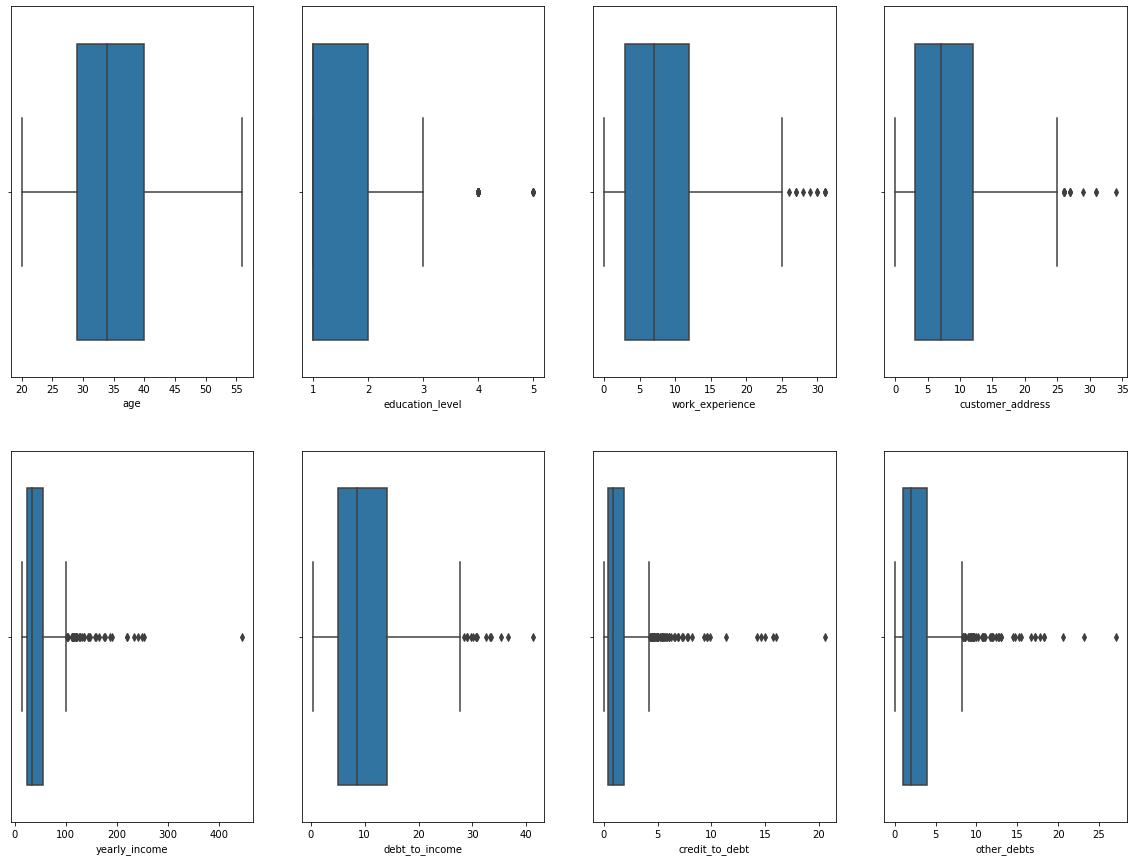

In [12]:
i = 0
j = 0
fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(20,15))
for item in df.columns.tolist():
    sns.boxplot(data=df,x=item,ax=axes[i][j])
    j+=1
    if j>3:
        j=0
        i+=1
        if i>1:
            break

Terlihat bahwa hampir seluruh kolom memiliki outlier, sehingga nantinya perlu dihandle

In [13]:

column_skew_dict = {'Normal':[],'Skew':[]}
for item in df.columns.tolist():
    if df[item].skew() > -0.5 and df[item].skew() < 0.5:
        column_skew_dict['Normal'].append(item)
    else :
        column_skew_dict['Skew'].append(item)

column_skew_dict

{'Normal': ['age'],
 'Skew': ['education_level',
  'work_experience',
  'customer_address',
  'yearly_income',
  'debt_to_income',
  'credit_to_debt',
  'other_debts',
  'credit_result']}

Kita lihat proporsi untuk label column 0 dan 1 ,apakah sudah seimbang atau belum . Jika tidak, maka perlu melakukan oversampling pada data training agar tidak terjadi imbalance dataset

In [14]:
keys = ['0','1']
value = df['credit_result'].value_counts(normalize=True).tolist()

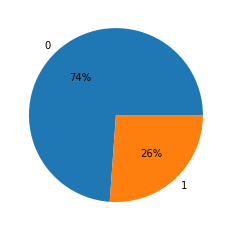

In [15]:
plt.figure(facecolor='#FFFFFF')
plt.pie(value,labels=keys,autopct='%.0f%%')
plt.show()

Terlihat bahwa proporsi untuk 0 dan 1 adalah 26/74 atau sekitar 0.28 sehingga perlu melakukan oversampling pada data train dengan label column 1 nantinya

### Checking Correlation between columns

Sebelum melakukan handling outlier, mari telaah kembali apakah ada korelasi antara feature column dengan yang lainnya, atau feature column dengan label columnnya

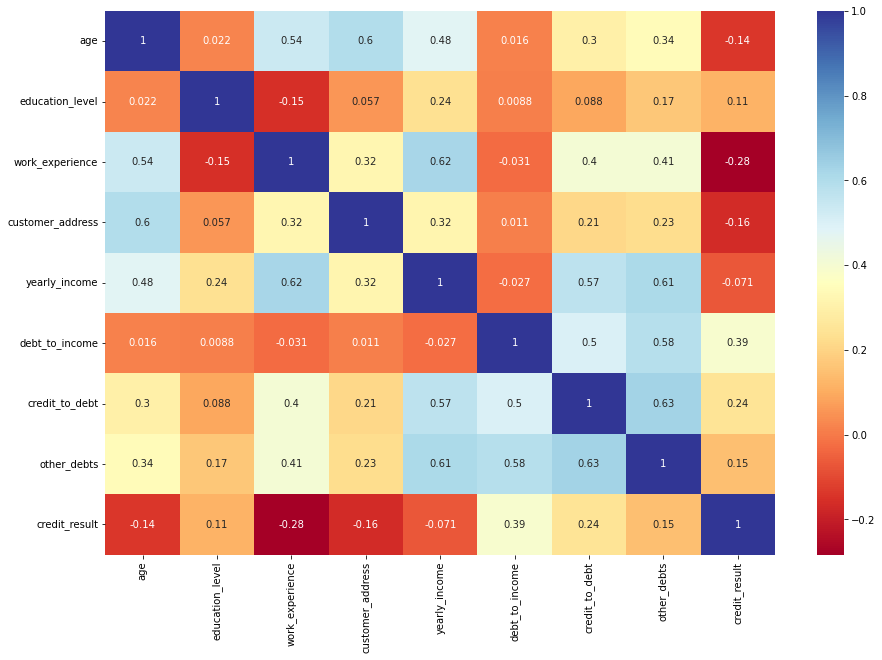

In [16]:
fig,ax = plt.subplots(figsize=(15,10),nrows=1,ncols=1)
sns.heatmap(df.corr(),annot=True,cmap='RdYlBu',ax=ax)
plt.show()

Dapat terlihat ketika mencari korelasi antara feature column dengan label column, secara sekilas :
- Age berbanding terbalik (kuat) dengan credit_result
- Education_level berbanding terbalik (kuat) dengan credit_result
- Customer_address berbanding terbalik (kuat) dengan credit_result
- Yearly_income berbanding terbalik (sangat kuat) dengan credit_result
- Other_debts berbanding terbalik (kuat) dengan credit result

Sedangkan untuk work_experience, debt_to_income, dan credit_to_debt memiliki korelasi yang tidak begitu kuat

Kemudian, tidak ada korelasi yang sangat kuat antara feature column satu dengan yang lainnya, sehingga tidak perlu untuk mengeliminasi feature column dengan alasan korelasi kuat dengan feature column lainnya

#### Korelasi antara age dengan credit result

<AxesSubplot:xlabel='credit_result', ylabel='age'>

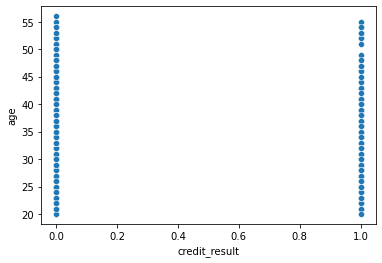

In [17]:
sns.scatterplot(y=df['age'],x=df['credit_result'])

Dari hasil di atas, terlihat bahwa age tidak berpengaruh secara signifikan terhadap credit_result

Namun, mari kita periksa dengan pearson correlation

In [18]:
pearson_corr, p_val = pearsonr(df['credit_result'],df['age'])

In [19]:
pearson_corr

-0.13765710211371435

In [20]:
p_val

0.0002592349567963635

Terlihat bahwa dengan pearson correlation, korelasi antara age dengan credit_result negatif signifikan, sehingga kolom age akan digunakan

#### Korelasi antara education_level dengan credit_result

<AxesSubplot:xlabel='credit_result', ylabel='education_level'>

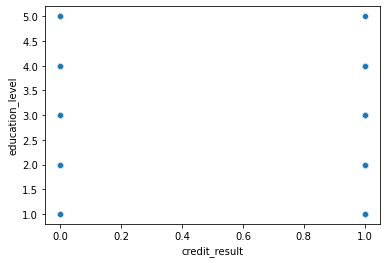

In [21]:
sns.scatterplot(x=df['credit_result'],y=df['education_level'])

Dari hasil di atas, terlihat bahwa education_level tidak berpengaruh secara signifikan terhadap credit_result

Namun, mari kita periksa dengan pearson correlation

In [22]:
pearson_corr, p_val = pearsonr(df['credit_result'],df['education_level'])

print('Pearson correlation : {} \nP_value : {}'.format(pearson_corr,p_val))

Pearson correlation : 0.1146755510161549 
P_value : 0.0023765086328479622


Terlihat bahwa dengan pearson correlation, korelasi antara education_level dan credit_result negatif signifikan, sehingga kolom education_level akan digunakan

#### Korelasi antara work_experience dengan credit_result

<AxesSubplot:xlabel='credit_result', ylabel='work_experience'>

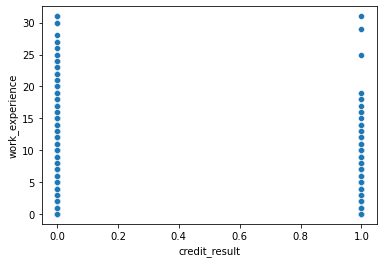

In [23]:
sns.scatterplot(x=df['credit_result'],y=df['work_experience'])

Dari hasil di atas, terlihat bahwa work experience di atas 20 tidak banyak yang memiliki credit_result = 1, sehingga kesimpulan kasar adalah work_experience memiliki korelasi dengan credit_result\

Namun, mari kita periksa dengan pearson correlation

In [24]:
pearson_corr, p_val = pearsonr(df['credit_result'],df['work_experience'])

print('Pearson correlation : {} \nP_value : {}'.format(pearson_corr,p_val))

Pearson correlation : -0.28297839296551197 
P_value : 2.347198389860361e-14


Terlihat bahwa p_value memiliki nilai di atas 0.05 yang artinya tidak ada signifikansi antara credit_result dengan work_experience. 

Sehingga, work_experience nantinya dapat dipertimbangkan untuk **dieliminasi** 

#### Korelasi antara customer_address dengan credit_result

<AxesSubplot:xlabel='credit_result', ylabel='customer_address'>

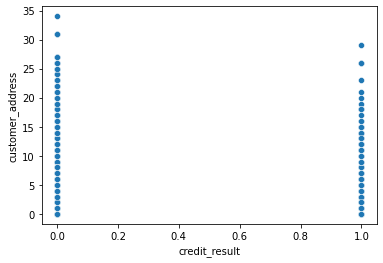

In [25]:
sns.scatterplot(x=df['credit_result'],y=df['customer_address'])

Dari hasil di atas, terlihat bahwa customer_address tidak berpengaruh secara signifikan terhadap credit_result

Namun, mari kita periksa dengan pearson correlation

In [26]:
pearson_corr, p_val = pearsonr(df['credit_result'],df['customer_address'])

print('Pearson correlation : {} \nP_value : {}'.format(pearson_corr,p_val))

Pearson correlation : -0.16445115872803898 
P_value : 1.225513044563205e-05


Terlihat bahwa p_value memiliki nilai di atas 0.05 yang artinya tidak ada signifikansi antara credit_result dengan customer_address . 

Sehingga, customer_address nantinya dapat dipertimbangkan untuk **dieliminasi** 

#### Korelasi antara yearly_income dengan credit_result

<AxesSubplot:xlabel='credit_result', ylabel='yearly_income'>

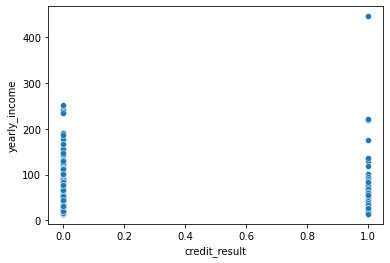

In [27]:
sns.scatterplot(x=df['credit_result'],y=df['yearly_income'])

Dari grafik di atas, terlihat bahwa ketika yearly_income di atas 130 memiliki credit_result 0

Namun dapat kita periksa kembali menggunakan pearson correlation

In [28]:
pearson_corr, p_val = pearsonr(df['credit_result'],df['yearly_income'])

print('Pearson correlation : {} \nP_value : {}'.format(pearson_corr,p_val))

Pearson correlation : -0.07096965661922351 
P_value : 0.06056036030014305


Terlihat bahwa p_value memiliki nilai di atas 0.05, maka artinya yearly_income tidak berpengaruh secara signifikan terhadap credit_result

Sehingga, yearly_income nantinya dapat dipertimbangkan untuk **dieliminasi**

#### Korelasi antara debt_to_income to credit_result

<AxesSubplot:xlabel='credit_result', ylabel='debt_to_income'>

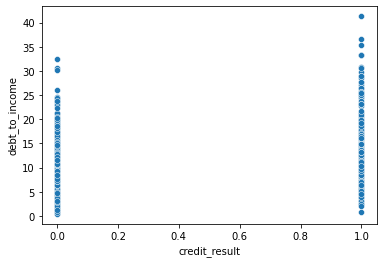

In [29]:
sns.scatterplot(x=df['credit_result'],y=df['debt_to_income'])

Pada grafik, terlihat sekilas bahwa ketika debt_to_income di atas 25 lebih banyak memiliki credit_result 1 dibandingkan tidak

Namun dapat kita periksa menggunakan pearson correlation

In [30]:
pearson_corr, p_val = pearsonr(df['credit_result'],df['debt_to_income'])

print('Pearson correlation : {} \nP_value : {}'.format(pearson_corr,p_val))

Pearson correlation : 0.38957475971770766 
P_value : 8.657458479679588e-27


Terlihat bahwa p_value memiliki nilai di atas 0.05, maka artinya debt_to_income tidak berpengaruh secara signifikan terhadap credit_result

Sehingga, debt_to_income nantinya dapat dipertimbangkan untuk **dieliminasi**

#### Korelasi antara credit_to_debt dengan credit_result

<AxesSubplot:xlabel='credit_result', ylabel='credit_to_debt'>

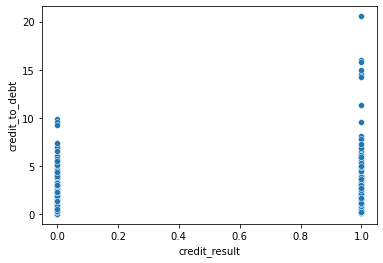

In [31]:
sns.scatterplot(x=df['credit_result'],y=df['credit_to_debt'])

Pada grafik, terlihat bahwa ketika credit_to_debt di atas 10, maka credit_resultnya adalah 1

Namun, kita dapat periksa menggunakan pearson correlation

In [32]:
pearson_corr, p_val = pearsonr(df['credit_result'],df['credit_to_debt'])

print('Pearson correlation : {} \nP_value : {}'.format(pearson_corr,p_val))

Pearson correlation : 0.24473972537225847 
P_value : 5.248665952603552e-11


Terlihat bahwa p_value memiliki nilai di atas 0.05, maka artinya credit_to_debt tidak berpengaruh secara signifikan terhadap credit_result

Sehingga, credit_to_debt nantinya dapat dipertimbangkan untuk **dieliminasi**

#### Korelasi antara other_debts dengan credit_result

<AxesSubplot:xlabel='credit_result', ylabel='other_debts'>

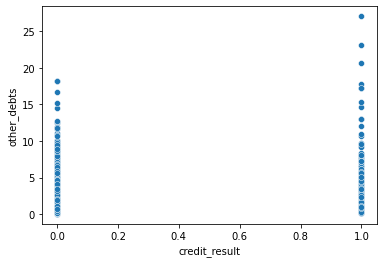

In [33]:
sns.scatterplot(x=df['credit_result'],y=df['other_debts'])

Pada grafik, terlihat bahwa other_debts tidak memiliki pengaruh yang signifikan terhadap credit_result

Namun, kita dapat periksa menggunakan pearson correlation

In [34]:
pearson_corr, p_val = pearsonr(df['credit_result'],df['other_debts'])

print('Pearson correlation : {} \nP_value : {}'.format(pearson_corr,p_val))

Pearson correlation : 0.1457125656007403 
P_value : 0.00010929611882480134


Terlihat bahwa P_value memiliki nilai di bawah 0.05, sehingga other_debts memiliki pengaruh yang signifikan terhadap credit_result

#### Korelasi antara education_level dengan yearly_income

Dengan *personal assumption* , saya ingin melihat apakah ada korelasi antara education_level dengan yearly_income

<AxesSubplot:xlabel='education_level', ylabel='yearly_income'>

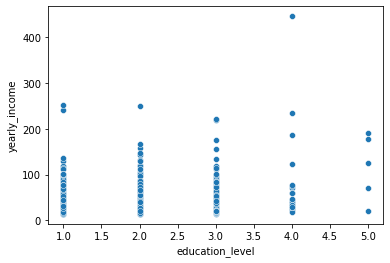

In [35]:
sns.scatterplot(x=df['education_level'],y=df['yearly_income'])

Terlihat bahwa education_level tidak memiliki pengaruh signifikan terhadap yearly_income. 

Namun, dapat diperiksa menggunakan pearson correlation

In [36]:
pearson_corr, p_val = pearsonr(df['education_level'],df['yearly_income'])

print('Pearson correlation : {} \nP_value : {}'.format(pearson_corr,p_val))

Pearson correlation : 0.23519049759557498 
P_value : 2.976171977417154e-10


Karena P_value memiliki nilai di atas 0.05, maka education_level dan yearly_income tidak memiliki pengaruh yang signifikan. 

## Train Test Split

Saya akan menggunakan splitting untuk data train dan test sehingga model dapat dilatih dengan data train, dan dievaluasi dengan data test

In [37]:
X = df.drop(columns='credit_result')
y = df['credit_result']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=46,stratify=y)

### Data train

In [39]:
X_train.head()

,age,education_level,work_experience,customer_address,yearly_income,debt_to_income,credit_to_debt,other_debts
657,35,1,16,10,57,10.5,1.143135,4.841865
190,27,2,4,3,22,13.2,1.086096,1.817904
35,26,2,6,7,45,26.0,6.048900,5.651100
351,22,1,1,3,17,18.6,0.806310,2.355690
446,32,3,5,9,23,4.5,0.326025,0.708975


In [40]:
y_train.head()

657    0.0
190    1.0
35     0.0
351    0.0
446    0.0
Name: credit_result, dtype: float64

### Data test

In [41]:
X_test.head()

,age,education_level,work_experience,customer_address,yearly_income,debt_to_income,credit_to_debt,other_debts
69,29,1,1,2,20,18.6,0.569160,3.150840
662,31,3,6,8,54,2.8,0.402192,1.109808
434,39,2,9,16,56,18.7,4.764760,5.707240
554,40,1,21,21,46,6.2,0.966828,1.885172
382,39,2,2,12,46,16.0,4.003840,3.356160


In [42]:
y_test.head()

69     1.0
662    0.0
434    0.0
554    0.0
382    1.0
Name: credit_result, dtype: float64

## Handling Outlier

Karena pada saat melakukan EDA , seluruh kolom mengandung outlier, maka perlu kita lihat, menggunakan extreme outlier (3x dari IQR nya), apakah banyak atau tidak (dapat menggunakan persentase dari total)

In [43]:
def upper_limit(data,variables):
    Q3 = np.percentile(data[variables],75)
    Q1 = np.percentile(data[variables],25)
    IQR = Q3 - Q1
    upper_boundary = Q3 + 3 * IQR
    return upper_boundary

for item in X_train.columns.tolist():
    print('Upper limit dari {} : {}'.format(item,upper_limit(X_train,item)))

Upper limit dari age : 77.0
Upper limit dari education_level : 5.0
Upper limit dari work_experience : 39.0
Upper limit dari customer_address : 39.0
Upper limit dari yearly_income : 153.0
Upper limit dari debt_to_income : 41.1
Upper limit dari credit_to_debt : 6.437769
Upper limit dari other_debts : 12.810103499999997


Dari upper limit yang telah diperoleh, maka kita lihat ada berapa jumlah outlier masing - masing kolom dengan kriteria outlier yaitu lebih dari upper limit di atas

In [44]:
for item in X_train.columns.tolist():
    jumlah_outlier = X_train[X_train[item]>upper_limit(X_train,item)].shape[0]
    persentase_outlier = jumlah_outlier / X_train[item].shape[0]
    print('Jumlah outlier pada {} adalah {}. Persentase : {}'.format(item,jumlah_outlier,persentase_outlier))

Jumlah outlier pada age adalah 0. Persentase : 0.0
Jumlah outlier pada education_level adalah 0. Persentase : 0.0
Jumlah outlier pada work_experience adalah 0. Persentase : 0.0
Jumlah outlier pada customer_address adalah 0. Persentase : 0.0
Jumlah outlier pada yearly_income adalah 13. Persentase : 0.023214285714285715
Jumlah outlier pada debt_to_income adalah 1. Persentase : 0.0017857142857142857
Jumlah outlier pada credit_to_debt adalah 19. Persentase : 0.033928571428571426
Jumlah outlier pada other_debts adalah 15. Persentase : 0.026785714285714284


Ternyata ada 4 kolom yang memiliki extreme outlier, sehingga kita coba untuk remove outlier dan periksa berapa yang terhapus karena adanya extreme outlier

Untuk menggunakan outlier trimmer, maka perlu menggabung terlebih dahulu feature column dengan label column nya agar label column nya juga di-trim

In [45]:
data_train = pd.concat([X_train,y_train],axis=1)
data_train

,age,education_level,work_experience,customer_address,yearly_income,debt_to_income,credit_to_debt,other_debts,credit_result
657,35,1,16,10,57,10.5,1.143135,4.841865,0.0
190,27,2,4,3,22,13.2,1.086096,1.817904,1.0
35,26,2,6,7,45,26.0,6.048900,5.651100,0.0
351,22,1,1,3,17,18.6,0.806310,2.355690,0.0
446,32,3,5,9,23,4.5,0.326025,0.708975,0.0
...,...,...,...,...,...,...,...,...,...
498,25,1,0,2,18,18.9,0.513702,2.888298,1.0
54,40,2,3,2,28,9.5,0.553280,2.106720,0.0
658,50,1,4,4,23,12.5,0.140875,2.734125,0.0
499,41,2,6,0,36,19.5,4.513860,2.506140,1.0


In [46]:
trimmer = OutlierTrimmer(capping_method="iqr",tail="right",fold=3,variables=['yearly_income','debt_to_income','credit_to_debt','other_debts'])
trimmer.fit(data_train)
data_train = trimmer.transform(data_train)

In [47]:
data_train

,age,education_level,work_experience,customer_address,yearly_income,debt_to_income,credit_to_debt,other_debts,credit_result
657,35,1,16,10,57,10.5,1.143135,4.841865,0.0
190,27,2,4,3,22,13.2,1.086096,1.817904,1.0
35,26,2,6,7,45,26.0,6.048900,5.651100,0.0
351,22,1,1,3,17,18.6,0.806310,2.355690,0.0
446,32,3,5,9,23,4.5,0.326025,0.708975,0.0
...,...,...,...,...,...,...,...,...,...
498,25,1,0,2,18,18.9,0.513702,2.888298,1.0
54,40,2,3,2,28,9.5,0.553280,2.106720,0.0
658,50,1,4,4,23,12.5,0.140875,2.734125,0.0
499,41,2,6,0,36,19.5,4.513860,2.506140,1.0


Sekarang split antara X_train dengan y_train

In [48]:
X_train = data_train.drop(columns='credit_result',axis=1)
y_train = data_train['credit_result']

## Handling Missing Values 

Karena tidak ada missing values , maka proses ini akan diskip

## Feature Importance

Sebelumnya pada EDA saya sudah mencoba melihat korelasi untuk masing - masing feature column dengan label column. 

Dan ternyata banyak yang tidak berpengaruh secara signifikan terhadap label columnnya sehingga dapat dipertimbangkan untuk tidak menggunakan feature column tersebut

Namun, saya akan mencoba melakukan feature importance dengan random forest classifier untuk memutuskan apakah perlu dieliminasi atau tidak

In [49]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
importance = model.feature_importances_

In [50]:
i = 0
for item in X :
    print(f'Feature importance dari {item} : {importance[i]}')
    i+=1

Feature importance dari age : 0.09673477553046218
Feature importance dari education_level : 0.04610385328724389
Feature importance dari work_experience : 0.14841043986341035
Feature importance dari customer_address : 0.10442901139006756
Feature importance dari yearly_income : 0.11885240536250735
Feature importance dari debt_to_income : 0.19339567348280087
Feature importance dari credit_to_debt : 0.1580820585735039
Feature importance dari other_debts : 0.13399178251000377


Saya menggunakan threshold 0.049, sehingga ada 1 kolom yang akan dieliminasi, yaitu **education_level**

In [51]:
X_train = X_train.drop(columns='education_level',axis=1)
X_test = X_test.drop(columns='education_level',axis=1)

## Feature Scaling

Karena range feature column nya masih bervariatif, maka perlu discaling. 

Karena distribusinya hampir seluruhnya skew, maka saya akan memanfaatkan MinMaxScaler

In [52]:
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
X_train_scaled

array([[0.41666667, 0.53333333, 0.29411765, ..., 0.28530259, 0.18541785,
        0.38024246],
       [0.19444444, 0.13333333, 0.08823529, ..., 0.36311239, 0.17607042,
        0.14050705],
       [0.16666667, 0.2       , 0.20588235, ..., 0.73198847, 0.98936432,
        0.44439748],
       ...,
       [0.83333333, 0.13333333, 0.11764706, ..., 0.34293948, 0.02116958,
        0.21314377],
       [0.58333333, 0.2       , 0.        , ..., 0.54466859, 0.73780519,
        0.19506944],
       [0.5       , 0.16666667, 0.14705882, ..., 0.28818444, 0.24384901,
        0.33128372]])

In [54]:
X_test_scaled

array([[ 0.25      ,  0.03333333,  0.05882353,  0.04477612,  0.51873199,
         0.09135603,  0.24618036],
       [ 0.30555556,  0.2       ,  0.23529412,  0.29850746,  0.06340058,
         0.06399367,  0.08437019],
       [ 0.52777778,  0.3       ,  0.47058824,  0.31343284,  0.52161383,
         0.77892216,  0.44884818],
       [ 0.55555556,  0.7       ,  0.61764706,  0.23880597,  0.16138329,
         0.15652503,  0.14583997],
       [ 0.52777778,  0.06666667,  0.35294118,  0.23880597,  0.44380403,
         0.65422418,  0.26245784],
       [ 0.16666667,  0.06666667,  0.02941176,  0.17164179,  0.39193084,
         0.03166285,  0.39667128],
       [ 0.27777778,  0.13333333,  0.05882353,  0.02985075,  0.29106628,
         0.03532749,  0.13105926],
       [ 0.11111111,  0.03333333,  0.        ,  0.02985075,  0.15273775,
         0.03724191,  0.06163642],
       [ 0.75      ,  0.43333333,  0.73529412,  0.2761194 ,  0.6685879 ,
         0.61074148,  0.66228647],
       [ 0.33333333,  0.3   

## Handling Imbalance Dataset - SMOTENC

Karena dataset bersifat imbalance antara label column 0 dan 1, maka kita perlu melakukan oversampling pada label column 1.

In [56]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=46)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled,y_train)

## Model Definition

Untuk dataset ini, saya akan mencoba menggunakan RandomForestClassifier

In [61]:
rfc = RandomForestClassifier()

## Model Training

In [62]:
rfc.fit(X_train_resampled,y_train_resampled)

RandomForestClassifier()

## Model Evaluation

In [65]:
cross_val_rfc = cross_val_score(rfc,X_train_resampled,y_train_resampled,scoring='f1',cv=5)
print("All Cross val score :",cross_val_rfc)
print("Mean Cross val score :",cross_val_rfc.mean())
print("Std Cross val score :",cross_val_rfc.std())
print("Range Cross val score :",cross_val_rfc.mean()-cross_val_rfc.std(),'-',cross_val_rfc.mean()+cross_val_rfc.std())

All Cross val score : [0.78980892 0.87341772 0.91954023 0.87804878 0.85057471]
Mean Cross val score : 0.8622780723465959
Std Cross val score : 0.042521779787034523
Range Cross val score : 0.8197562925595614 - 0.9047998521336305


Dari hasil di atas, terlihat bahwa algoritma Random Forest Classifier cukup baik dalam melakukan prediksi (dengan cv = 5, dapat memperoleh interval range 81 - 90 persen) ketika menggunakan data train

Sekarang mari kita lihat classification reportnya saat menggunakan data test

In [70]:
y_pred_test = rfc.predict(X_test_scaled)

print('Classification report: ')
print(classification_report(y_test,y_pred_test))

Classification report: 
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       103
         1.0       0.45      0.49      0.47        37

    accuracy                           0.71       140
   macro avg       0.63      0.64      0.63       140
weighted avg       0.71      0.71      0.71       140



## Additional Algorithm Use (For Comparison)

Disini saya akan memanfaatkan algoritma lain , seperti Logistic Regression, SVC (Support Vector Classifier), serta Decision Tree Classifier

In [91]:
logreg = LogisticRegression()
svclassifier = SVC()
decisiontree = DecisionTreeClassifier()

In [94]:
logreg.fit(X_train_resampled,y_train_resampled)
svclassifier.fit(X_train_resampled,y_train_resampled)
decisiontree.fit(X_train_resampled,y_train_resampled)

AdaBoostClassifier()

## Model Evaluation for Addition Algorithm Use

### Logistic Regression

In [77]:
cross_val_logreg = cross_val_score(logreg,X_train_resampled,y_train_resampled,scoring='f1',cv=5)
print("All Cross val score :",cross_val_logreg)
print("Mean Cross val score :",cross_val_logreg.mean())
print("Std Cross val score :",cross_val_logreg.std())
print("Range Cross val score :",cross_val_logreg.mean()-cross_val_logreg.std(),'-',cross_val_logreg.mean()+cross_val_logreg.std())

All Cross val score : [0.72289157 0.79503106 0.84023669 0.75949367 0.77647059]
Mean Cross val score : 0.7788247135355169
Std Cross val score : 0.03883767249005114
Range Cross val score : 0.7399870410454658 - 0.817662386025568


In [78]:
y_pred_test = logreg.predict(X_test_scaled)

print('Classification report - Logistic Regression: ')
print(classification_report(y_test,y_pred_test))

Classification report - Logistic Regression: 
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83       103
         1.0       0.55      0.78      0.64        37

    accuracy                           0.77       140
   macro avg       0.73      0.78      0.74       140
weighted avg       0.81      0.77      0.78       140



Dari hasil di atas, untuk Logistic Regression dapat disimpulkan bahwa :
- Range untuk cross validation menghasilkan angka dari 73 hingga 81 persen, yang dapat terbilang cukup baik
- Accuracy saat menggunakan data test menghasilkan angka 77 persen, dimana masih berada dalam interval cross validation saat menggunakan data train, yang artinya akurasi memberikan hasil cukup stabil dengan data trainnya
- Precision untuk label column 0 menghasilkan angka 91 persen, yang artinya dari seluruh yang terprediksi 0 , ada 91% yang benar - benar 0
- Precision untuk label column 1 menghasilkan angka 55 persen, yang artinya dari seluruh yang terprediksi 1, ada 55% yang benar - benar 1
- Recall untuk label column 0 menghasilkan angka 77 persen, yang artinya dari seluruh sampel yang benar - benar 0, ada 77% proporsi yang terprediksi 0
- Recall untuk label column 1 menghasilkan angka 78 persen, yang artinya dari seluruh sampel yang benar - benar 1, ada 78% proporsi yang terprediksi 1

### Support Vector

In [79]:
cross_val_svc = cross_val_score(svclassifier,X_train_resampled,y_train_resampled,scoring='f1',cv=5)
print("All Cross val score :",cross_val_svc)
print("Mean Cross val score :",cross_val_svc.mean())
print("Std Cross val score :",cross_val_svc.std())
print("Range Cross val score :",cross_val_svc.mean()-cross_val_svc.std(),'-',cross_val_svc.mean()+cross_val_svc.std())

All Cross val score : [0.77844311 0.83229814 0.85057471 0.77714286 0.82485876]
Mean Cross val score : 0.8126635154534199
Std Cross val score : 0.029679131381126534
Range Cross val score : 0.7829843840722933 - 0.8423426468345464


In [80]:
y_pred_test = svclassifier.predict(X_test_scaled)

print('Classification report - Support Vector Classifier: ')
print(classification_report(y_test,y_pred_test))

Classification report - Support Vector Classifier: 
              precision    recall  f1-score   support

         0.0       0.90      0.76      0.82       103
         1.0       0.53      0.76      0.62        37

    accuracy                           0.76       140
   macro avg       0.71      0.76      0.72       140
weighted avg       0.80      0.76      0.77       140



Dari hasil di atas, untuk Support Vector dapat disimpulkan bahwa :

- Range untuk cross validation menghasilkan angka dari 78 hingga 84 persen, yang dapat terbilang cukup baik
- Accuracy saat menggunakan data test menghasilkan angka 76 persen, dimana tidak berada dalam interval cross validation score, sehingga dapat dipertimbangkan untuk tidak menggunakan data tersebut (underfitting)



### Decision Tree Classifier

In [81]:
cross_val_dt = cross_val_score(decisiontree,X_train_resampled,y_train_resampled,scoring='f1',cv=5)
print("All Cross val score :",cross_val_dt)
print("Mean Cross val score :",cross_val_dt.mean())
print("Std Cross val score :",cross_val_dt.std())
print("Range Cross val score :",cross_val_dt.mean()-cross_val_dt.std(),'-',cross_val_dt.mean()+cross_val_dt.std())

All Cross val score : [0.63576159 0.80503145 0.87719298 0.80246914 0.78571429]
Mean Cross val score : 0.7812338879835499
Std Cross val score : 0.07925613032828573
Range Cross val score : 0.7019777576552642 - 0.8604900183118356


In [82]:
y_pred_test = decisiontree.predict(X_test_scaled)

print('Classification report - Decision Tree Classifier : ')
print(classification_report(y_test,y_pred_test))

Classification report - Decision Tree Classifier : 
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       103
         1.0       0.53      0.51      0.52        37

    accuracy                           0.75       140
   macro avg       0.68      0.67      0.68       140
weighted avg       0.75      0.75      0.75       140



Dari hasil di atas, untuk Decision Tree dapat disimpulkan bahwa :

- Range untuk cross validation menghasilkan angka dari 70 hingga 86 persen, yang dapat terbilang cukup baik
- Accuracy saat menggunakan data test menghasilkan angka 75 persen, dimana masih dalam interval cross validation score dengan data train
- Accuracy yang dihasilkan sebesar 75 persen, yang masih lebih kecil dibandingkan Logistic Regression sebesar 75 persen


Karena algoritma yang lebih stabil dengan nilai cukup baik berada pada logistic regression, maka saya akan mencoba melakukan improvement pada algoritma ini

## Model Improvement - Logistic Regression

In [102]:
train_columns = X_train.columns.tolist()
train_columns

['age',
 'work_experience',
 'customer_address',
 'yearly_income',
 'debt_to_income',
 'credit_to_debt',
 'other_debts']

In [103]:
num_pipeline = make_pipeline(scaler)

data_pipeline = ColumnTransformer([
        ('pipe_num',num_pipeline,train_columns)
])

final_pipeline = Pipeline([
        ('data_pipe',data_pipeline),
        ('smote',sm),
        ('logreg',logreg)
])

In [115]:
data_train_resampled = pd.DataFrame(X_train_resampled,columns=train_columns)
data_test_scaled = pd.DataFrame(X_test_scaled,columns=train_columns)
data_train_resampled

,age,work_experience,customer_address,yearly_income,debt_to_income,credit_to_debt,other_debts
0,0.416667,0.533333,0.294118,0.320896,0.285303,0.185418,0.380242
1,0.194444,0.133333,0.088235,0.059701,0.363112,0.176070,0.140507
2,0.166667,0.200000,0.205882,0.231343,0.731988,0.989364,0.444397
3,0.055556,0.033333,0.088235,0.022388,0.518732,0.130220,0.183142
4,0.333333,0.166667,0.264706,0.067164,0.112392,0.051512,0.052593
...,...,...,...,...,...,...,...
793,0.758713,0.047930,0.415418,0.048971,0.435723,0.152080,0.177728
794,0.109375,0.064583,0.082721,0.087220,0.259906,0.146866,0.120595
795,0.290504,0.118909,0.095401,0.194437,0.675536,0.921577,0.316452
796,0.144457,0.083994,0.116482,0.066573,0.762285,0.423820,0.273075


In [108]:
parameters = {
    'logreg__penalty' : ['l1', 'l2'],
    'logreg__C' : np.logspace(-4, 4, 20),
    'logreg__solver' : ['liblinear']
}

grid_pipe = GridSearchCV(final_pipeline,param_grid=parameters,cv=5)
grid_pipe.fit(data_train_resampled,y_train_resampled)
print("Best parameters : {}".format(grid_pipe.best_params_))

Best parameters : {'logreg__C': 1.623776739188721, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}


In [109]:
grid_pipe_best = grid_pipe.best_estimator_
grid_pipe_best

Pipeline(steps=[('data_pipe',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'work_experience',
                                                   'customer_address',
                                                   'yearly_income',
                                                   'debt_to_income',
                                                   'credit_to_debt',
                                                   'other_debts'])])),
                ('smote', SMOTE(random_state=46)),
                ('logreg',
                 LogisticRegression(C=1.623776739188721, solver='liblinear'))])

In [111]:
grid_pipe_best.fit(data_train_resampled,y_train_resampled)

Pipeline(steps=[('data_pipe',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'work_experience',
                                                   'customer_address',
                                                   'yearly_income',
                                                   'debt_to_income',
                                                   'credit_to_debt',
                                                   'other_debts'])])),
                ('smote', SMOTE(random_state=46)),
                ('logreg',
                 LogisticRegression(C=1.623776739188721, solver='liblinear'))])

In [116]:
y_test_pred = grid_pipe_best.predict(data_test_scaled)

In [117]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84       103
         1.0       0.56      0.78      0.65        37

    accuracy                           0.78       140
   macro avg       0.73      0.78      0.74       140
weighted avg       0.82      0.78      0.79       140



Dari tuning model untuk algoritma logistic regression, dapat terlihat bahwa ada kenaikan accuracy sebesar 1%. Dapat dikatakan kenaikannya tidak begitu signifikan. 

Sehingga kesimpulan untuk hasil penentuan model untuk credit risk analysis ini adalah :
- Untuk sementara, Logistic Regression adalah model yang paling baik dibandingkan dengan model lain
- Akurasi yang dihasilkan tertinggi dengan nilai stabil tanpa overfit atau underfit adalah sebesar 78%, yang artinya masih dalam kategori cukup baik.
- Namun, untuk mendapatkan hasil yang lebih maksimal, dapat mempertimbangkan untuk menambahkan sample label column '1' agar seimbang dengan '0' , atau memanfaatkan feature engineering lainnya yang lebih sesuai sehingga akurasinya dapat lebih baik.